## Train model for accumulation area of all glaciers


In [1]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold
from matplotlib import pyplot as plt

from model_functions import select_variables
from model_functions import train_xgb_model



In [2]:
# Specify filepaths and filenames.
loc = 'local'

if loc == 'cryocloud':
    filepath = '/home/jovyan/ML_MB_Norway_data/'
elif loc == 'local':
    filepath = 'Data/'

filename = '2023-06-27_stake_mb_norway_cleaned_ids_latlon_wattributes_climate.csv'

# Load data.
data = pd.read_csv(filepath + filename)

# Add year column
data['year']=pd.to_datetime(data['dt_curr_year_max_date'].astype('string'), format="%d.%m.%Y %H:%M")
data['year'] = data.year.dt.year.astype('Int64')

# Remove cells with nan in balance_netto.
glacier_data_all = data[data['balance_netto'].notna()]
glacier_data_all.reset_index(drop=True, inplace=True)
glacier_data_all


,RGIID,GLIMSID,BREID,utm_zone,utm_east_approx,utm_north_approx,altitude_approx,location_description,location_id,stake_no,...,tp_feb,tp_mar,tp_apr,tp_may,tp_jun,tp_jul,tp_aug,tp_sep,altitude_climate,year
0,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1012,...,0.005116,0.002688,0.002334,0.001159,0.003054,0.003977,0.004691,0.001449,341.227919,2013
1,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1013,...,0.001831,0.004597,0.005634,0.002244,0.003412,0.000891,0.002129,0.004860,341.227919,2014
2,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1013,...,0.004949,0.003286,0.003739,0.004709,0.005111,0.001253,0.002506,0.003256,341.227919,2015
3,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1013,...,0.002495,0.002263,0.001256,0.002129,0.003969,0.003559,0.002119,0.002851,341.227919,2016
4,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1016,...,0.003314,0.004417,0.002704,0.003991,0.001780,0.004257,0.005193,0.000710,341.227919,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3834,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1509,...,0.011964,0.007288,0.003555,0.005019,0.004730,0.007226,0.005739,0.011397,917.419759,2012
3835,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1509,...,0.002572,0.000807,0.009360,0.006135,0.006760,0.005158,0.008218,0.005461,917.419759,2013
3836,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1514,...,0.008543,0.010311,0.006261,0.008175,0.005974,0.006563,0.008015,0.003896,917.419759,2015
3837,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1514,...,0.008916,0.003751,0.004573,0.004449,0.005235,0.008926,0.011151,0.009556,917.419759,2016


In [3]:
# Select data where annual mass balance is less than zero.
glacier_data_acc = glacier_data_all[glacier_data_all['balance_netto'] >= 0]
glacier_data_acc.reset_index(drop=True, inplace=True)

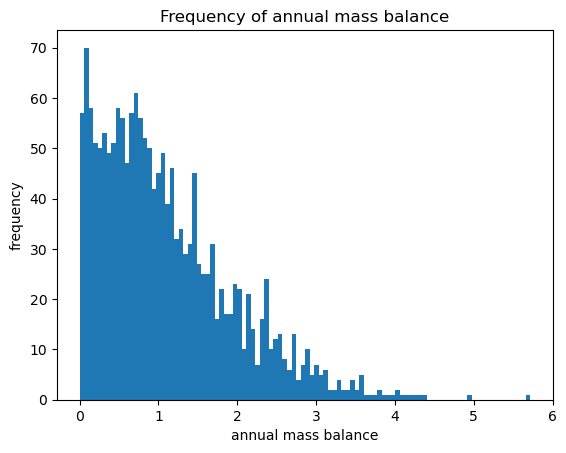

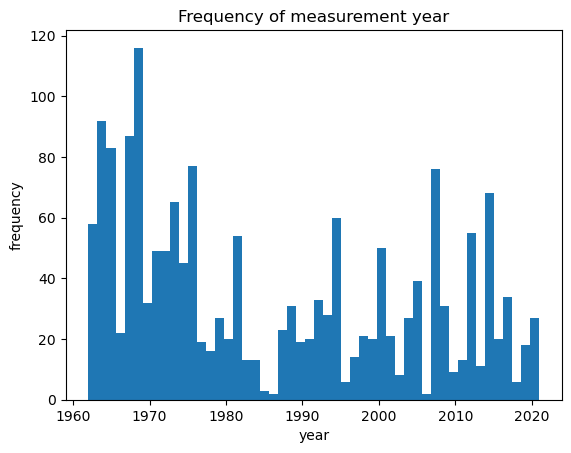

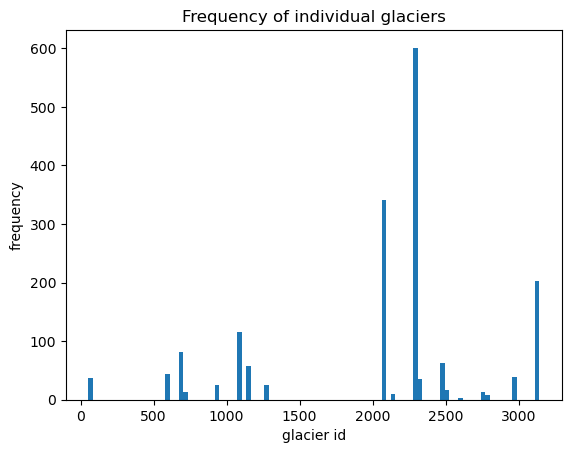

Number of glaciers: 31
Number of years: 60
Number of measurements:  1732
Number of mb > 3:  54
Glaciers with mb > 3  [ 941 1135 2078 2297 2320 3127 3133 3137 3141]


In [4]:
plt.figure()
glacier_data_acc['balance_netto'].plot.hist(bins=100)
plt.title('Frequency of annual mass balance')
plt.ylabel('frequency')
plt.xlabel('annual mass balance')
plt.show()

plt.figure()
glacier_data_acc['year'].plot.hist(bins=50)
plt.title('Frequency of measurement year')
plt.ylabel('frequency')
plt.xlabel('year')
plt.show()

plt.figure()
glacier_data_acc['BREID'].plot.hist(bins=100)
plt.title('Frequency of individual glaciers')
plt.ylabel('frequency')
plt.xlabel('glacier id')
plt.show()

print('Number of glaciers:', glacier_data_acc['BREID'].unique().shape[0])
print('Number of years:', glacier_data_acc['year'].unique().shape[0])
print('Number of measurements: ', glacier_data_acc.shape[0])
print('Number of mb > 3: ', glacier_data_all[glacier_data_all['balance_netto'] >= 3].shape[0])
print('Glaciers with mb > 3 ', glacier_data_all[glacier_data_all['balance_netto'] >= 3]['BREID'].unique())

## Leave glaciers out
Ideally use leave years and glaciers out.
Folds need to simultaneously block out glaciers and years, while maintaining a good balance of mass balance values.

1732/5 = 346.4 points in each fold with 5 folds

1732/4 = 433 points in each fold with 4 folds

1732/3 = 577.3 points in each fold with 3 folds

Nigardsbreen (2297) has 601 points

Ålfotbreen (2078) has 305 points


In [5]:
list(glacier_data_acc['BREID'].unique())

[54,
 596,
 675,
 703,
 941,
 1092,
 1094,
 1135,
 1144,
 1280,
 2078,
 2085,
 2148,
 2297,
 2320,
 2474,
 2478,
 2514,
 2597,
 2768,
 2769,
 2772,
 2968,
 3126,
 3127,
 3128,
 3129,
 3133,
 3137,
 3138,
 3141]

In [6]:
test_glaciers = [54, 703, 941, 1135, 1280, 2085, 2320, 2768, 2478, 2769, 3127, 3141]

df_test = glacier_data_acc[glacier_data_acc['BREID'].isin(test_glaciers)]
# 54 has 37 points
# 703 has 13 points
# 1280 has 25 points
# 2478 has 22 points
# 2769 has 10 points
# 3127 has 60 points

# test has 323 points in total

df_train = glacier_data_acc[~glacier_data_acc['BREID'].isin(test_glaciers)]


In [7]:
base_cols = ['altitude','aspect','slope','altitude_climate']
temp_cols = ['t2m_oct','t2m_nov','t2m_des','t2m_jan','t2m_feb','t2m_mar','t2m_apr','t2m_may','t2m_jun','t2m_jul','t2m_aug','t2m_sep']
prec_cols = ['tp_oct','tp_nov','tp_des','tp_jan','tp_feb','tp_mar','tp_apr','tp_may','tp_jun','tp_jul','tp_aug','tp_sep']
label_cols = ['balance_netto']

df_train_X = select_variables(df_train, base_cols, temp_cols, prec_cols)
df_train_y = select_variables(df_train, label_cols)
df_test_X = select_variables(df_test, base_cols, temp_cols, prec_cols)
df_test_y = select_variables(df_test, label_cols)

# 1409 for training (19 glaciers), 323 for testing (12 glaciers)
X_train, y_train = df_train_X.values, df_train_y.values
X_test, y_test = df_test_X.values, df_test_y.values

In [8]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}

In [9]:
gp = np.array(df_train['BREID'].values)

In [10]:
group_kf = GroupKFold(n_splits=5)
splits = list(group_kf.split(X_train, y_train, gp))

# Two of the splits have more test values. Split one where Nigardsbreen (approx 600 pts) 
# is test and split 2 where Ålfotbreen (approx 300 pts) is test. 
# With three folds, test sets will be more balanced in terms of number of points and glaciers. 

Fitting 5 folds for each of 392 candidates, totalling 1960 fits
Cross validation score:  -0.523340801748396
Grid search best hyperparameters:  {'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 50}
Cross validation scores per fold:  [-0.91341507 -0.39631113 -0.42435115 -0.38463063 -0.49799601]
Mean cross validation score:  -0.523340801748396
Standard deviation:  0.1989855743927368


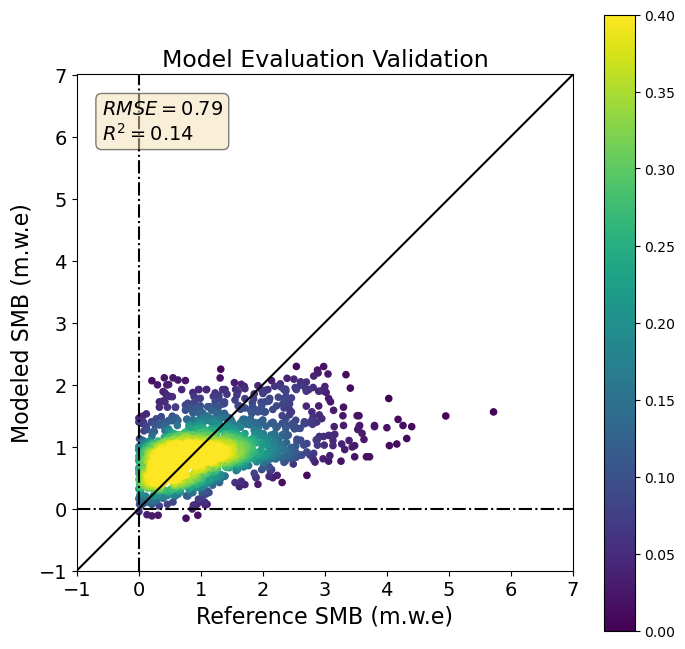

In [11]:
best_model = train_xgb_model(X_train, y_train, splits, param_ranges, scorer='neg_mean_squared_error')

Fitting 5 folds for each of 392 candidates, totalling 1960 fits
Cross validation score:  -0.4123558373451234
Grid search best hyperparameters:  {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 50}
Cross validation scores per fold:  [-0.88270173 -0.44530786 -0.44722094 -0.34856521 -0.60004344]
Mean cross validation score:  -0.5447678382393935
Standard deviation:  0.18716723313688713


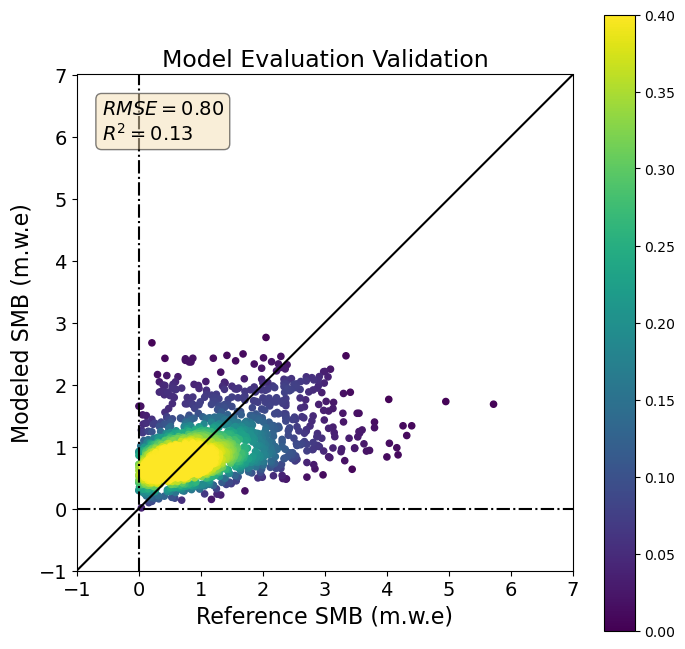

In [12]:
# Try with median absolute error instead of mean squared error (median squared error is not available). 

best_model_median = train_xgb_model(X_train, y_train, splits, param_ranges, scorer='neg_median_absolute_error')

## Use fewer folds

Using 3 folds instead of 5

In [13]:
group_kf = GroupKFold(n_splits=3)
splits = list(group_kf.split(X_train, y_train, gp))

# Train / test
# 808 / 601
# 601 / 1006 (Nigardsbreen)
# 1004 / 405

Fitting 3 folds for each of 392 candidates, totalling 1176 fits
Cross validation score:  -0.5945463496111664
Grid search best hyperparameters:  {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 400}
Cross validation scores per fold:  [-0.93449102 -0.4423009  -0.40684712]
Mean cross validation score:  -0.5945463496111664
Standard deviation:  0.24081255183597325


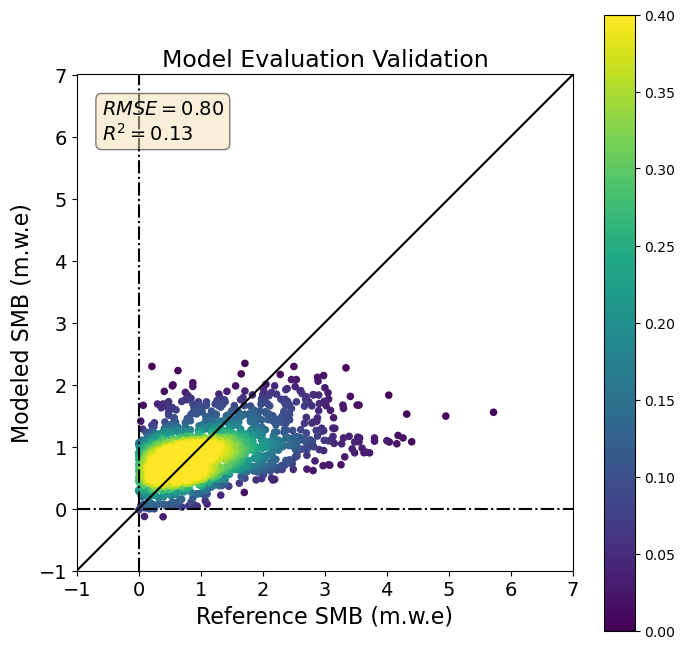

In [14]:
best_model = train_xgb_model(X_train, y_train, splits, param_ranges, scorer='neg_mean_squared_error')

## Shuffle glaciers first - NOT WORKING, GIVES THE SAME FOLDS AS WITHOUT SHUFFLE, NEED TO SHUFFLE DATASET FIRST.


In the above, glaciers are not shuffled prior to Group-K-fold split, such that they are to a large degree gouped by region. This likely leads to some folds with glaciers that have large mass turnover and some folds with glaciers that have low mass turnover, and thus extrapolation issues for large values. Try shuffle glaciers first and then Group-K-fold split. 

In [30]:
# Shuffle df_train, get X and y values
df_train_s = df_train.sample(frac=1, random_state=5)

df_train_X_s = select_variables(df_train_s, base_cols, temp_cols, prec_cols)
df_train_y_s = select_variables(df_train_s, label_cols)

X_train_s, y_train_s = df_train_X_s.values, df_train_y_s.values

gp_s = np.array(df_train_s['BREID'].values)

In [31]:
# Shuffle groups
#unique_values, indexes, inverse = np.unique(gp, return_inverse=True, return_index=True)
#gp_new = indexes[inverse]
#gp_new
print(gp)
print(gp_s)

[ 596  596  596 ... 3138 3138 3138]
[2297 2968 2297 ... 2297 1094 2297]


In [23]:
# With five folds
group_kf = GroupKFold(n_splits=5)
splits_s = list(group_kf.split(X_train_s, y_train_s, gp_s))

In [34]:
#splits[0][1]

In [35]:
#splits_s[0][1]

In [54]:
len(splits[2][1])

# 808 /601
# 1104 / 305
# 1241 / 168
# 1241 / 168
# 1242 / 167

168

Fitting 5 folds for each of 392 candidates, totalling 1960 fits
Cross validation score:  -0.523340801748396
Grid search best hyperparameters:  {'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 50}
Cross validation scores per fold:  [-0.91341507 -0.39631113 -0.42435115 -0.38463063 -0.49799601]
Mean cross validation score:  -0.523340801748396
Standard deviation:  0.1989855743927368


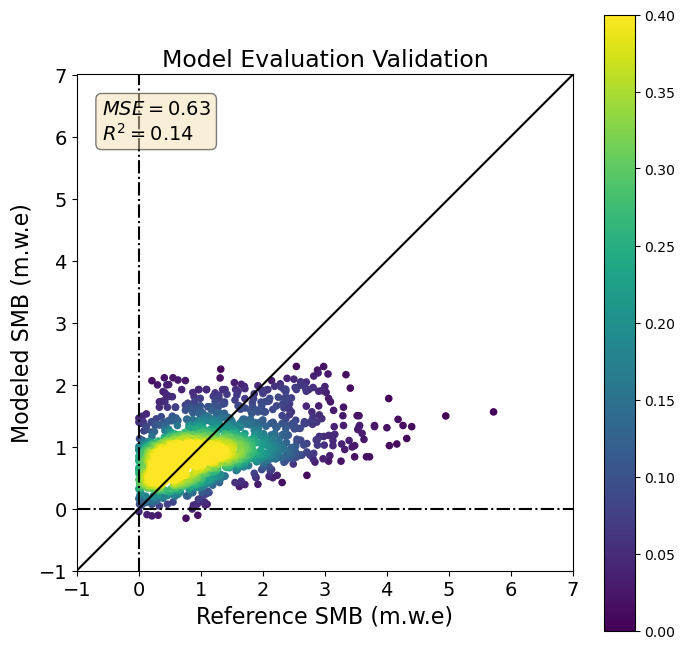

In [29]:
best_model = train_xgb_model(X_train_s, y_train_s, splits_s, param_ranges, scorer='neg_mean_squared_error')

In [32]:
# With five folds
group_kf = GroupKFold(n_splits=3)
splits_s = list(group_kf.split(X_train_s, y_train_s, gp_s))

Fitting 3 folds for each of 392 candidates, totalling 1176 fits
Cross validation score:  -0.5945463496111664
Grid search best hyperparameters:  {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 400}
Cross validation scores per fold:  [-0.93449102 -0.4423009  -0.40684712]
Mean cross validation score:  -0.5945463496111664
Standard deviation:  0.24081255183597325


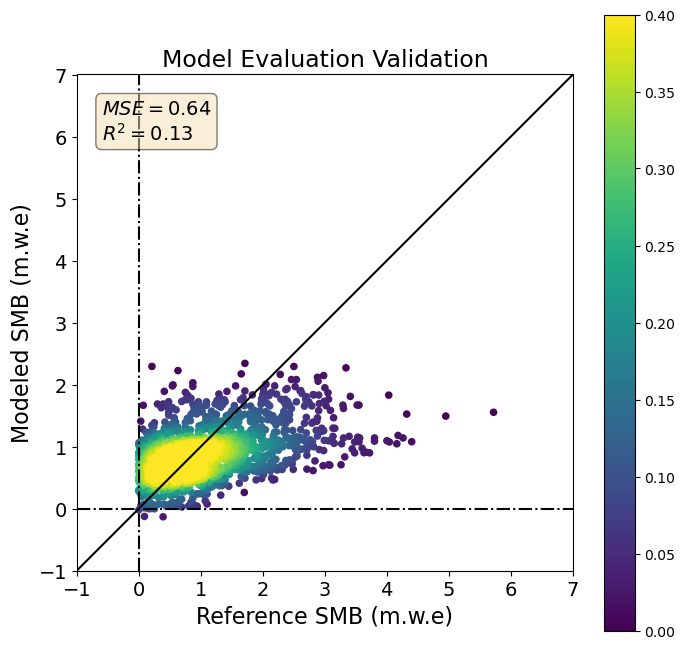

In [33]:
best_model = train_xgb_model(X_train_s, y_train_s, splits_s, param_ranges, scorer='neg_mean_squared_error')

In [ ]:
#With shuffling, three folds: Cross validation scores per fold:  [-0.93449102 -0.4423009  -0.40684712]

#Without shuffling, three folds: Cross validation scores per fold:  [-0.93449102 -0.4423009  -0.40684712]


## Upsample glaciers
